# **NLP with Disaster Tweets: The Grandmaster Approach**

สวัสดีครับ! นี่คือ Notebook สำหรับการแก้โจทย์ **NLP with Disaster Tweets** แบบทีละขั้นตอน (Step-by-step) โดยเราจะเน้นความเข้าใจในข้อมูลและโมเดลครับ

**Goal:** จำแนกข้อความทวีตว่าเป็นภัยพิบัติจริง (1) หรือไม่จริง (0)
**Technique:** เราจะใช้ Transformer Model (DistilBERT/RoBERTa) ซึ่งเป็น State-of-the-Art สำหรับงาน NLP

## 1. Setup & Library Import
เริ่มจากการ Import libraries ที่จำเป็น และตั้งค่า Seed เพื่อให้ผลลัพธ์คงที่ (Reproducibility) ครับ

In [17]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import logging
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# ปิด Warning เพื่อความสะอาดของ Output
import warnings
warnings.filterwarnings('ignore')
logging.set_verbosity_error()

In [18]:
def seed_everything(seed=42):
    """
    ตั้งค่า Seed สำหรับทุกๆ library เพื่อให้ผลลัพธ์เหมือนเดิมทุกครั้งที่รัน (Reproducibility)
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)
print("Seed Set: 42")

Seed Set: 42


## 2. Load Data
โหลดข้อมูล Train และ Test มาดูหน้าตากันก่อนครับ

In [19]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

print(f"Training Data Shape: {df_train.shape}")
print(f"Test Data Shape: {df_test.shape}")
df_train.head()

Training Data Shape: (7613, 5)
Test Data Shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## 3. Exploratory Data Analysis (EDA)
**"Know Thy Data"** - ก่อนจะสร้างโมเดล เราต้องรู้จักข้อมูลของเราก่อนครับ

### 3.1 Target Distribution
เช็คดูว่าข้อมูล Disaster (1) กับ Non-Disaster (0) มีสัดส่วนเท่าไหร่

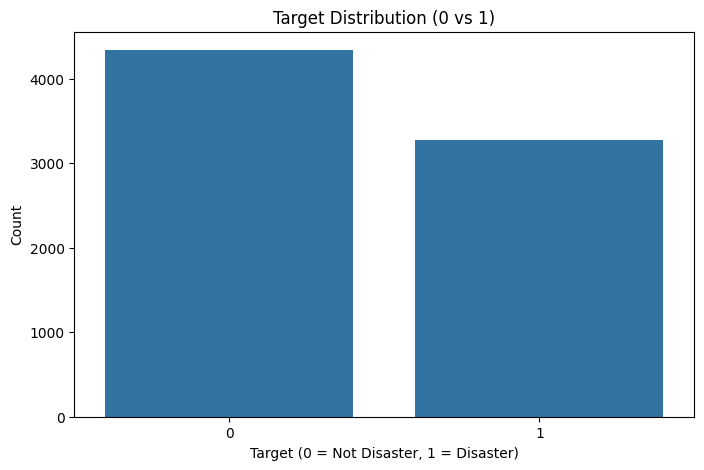

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df_train)
plt.title('Target Distribution (0 vs 1)')
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)')
plt.ylabel('Count')
plt.show()

print(df_train['target'].value_counts(normalize=True))

### 3.2 Tweet Length Analysis
ดูว่าความยาวของข้อความ (Character count) แตกต่างกันไหมระหว่างข่าวจริงกับข่าวปลอม

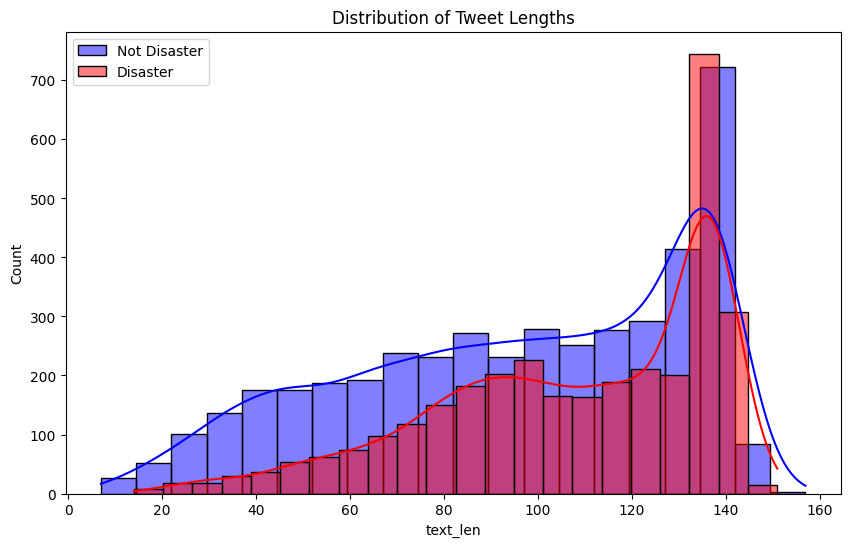

In [21]:
# สร้าง column ใหม่เก็บความยาวข้อความ
df_train['text_len'] = df_train['text'].astype(str).apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df_train[df_train['target']==0]['text_len'], label='Not Disaster', kde=True, color='blue', alpha=0.5)
sns.histplot(df_train[df_train['target']==1]['text_len'], label='Disaster', kde=True, color='red', alpha=0.5)
plt.legend()
plt.title('Distribution of Tweet Lengths')
plt.show()

## 4. Data Preprocessing & Feature Engineering
เราจะจัดการกับข้อมูล Missing Value และเตรียมข้อมูลให้พร้อมสำหรับ Transformer Model ครับ

**Strategy:**
1. **Handle Missing Values:** Column `keyword` มีค่า NaN อยู่ เราจะแทนที่ด้วยข้อความว่าง (Empty String) หรือ "unknown"
2. **Combine Text:** เราจะเอา `keyword` มาต่อกับ `text` เพื่อให้โมเดลได้รับข้อมูลบริบทมากขึ้น (เช่น `keyword [SEP] text`)
3. **Tokenization:** แปลงข้อความเป็นตัวเลข (Token IDs) โดยใช้ `AutoTokenizer`

In [22]:
# แทนที่ NaN ใน keyword ด้วย ""
df_train['keyword'] = df_train['keyword'].fillna("")
df_test['keyword'] = df_test['keyword'].fillna("")

# สร้างฟีเจอร์ใหม่: เอา keyword มานำหน้า text
# Format: "KEYWORD: <keyword_text> | TWEET: <tweet_text>"
# หมายเหตุ: Transformer ฉลาดพอที่จะแยกแยะบริบทได้ การใส่ Keyword เข้าไปช่วยเพิ่ม Accuracy ได้ครับ

df_train['final_text'] = df_train['keyword'] + " [SEP] " + df_train['text']
df_test['final_text'] = df_test['keyword'] + " [SEP] " + df_test['text']

print("Exampel Final Text:")
print(df_train['final_text'].iloc[0])

Exampel Final Text:
 [SEP] Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all


## 5. Tokenizer & Dataset Class
เราจะใช้ **DistilBERT** (`distilbert-base-uncased`) ซึ่งเป็นโมเดลที่เล็กและเร็ว แต่ให้ผลลัพธ์ใกล้เคียง BERT ตัวใหญ่

**Note:** ต้องใช้ Tokenizer ตัวเดียวกับ Pre-trained Model ที่เราเลือกเสมอครับ

In [23]:
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ลอง Tokenize ดูตัวอย่าง
sample_text = df_train['final_text'].iloc[0]
encoded_input = tokenizer(sample_text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')

print(f"Original: {sample_text}")
print(f"Token IDs: {encoded_input['input_ids']}")

'(MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /distilbert-base-uncased/resolve/main/tokenizer_config.json (Caused by NameResolutionError("HTTPSConnection(host=\'huggingface.co\', port=443): Failed to resolve \'huggingface.co\' ([Errno -3] Temporary failure in name resolution)"))'), '(Request ID: 5f17fdf9-f71f-429f-a043-b7c1664b988f)')' thrown while requesting HEAD https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


Original:  [SEP] Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Token IDs: tensor([[  101,   102,  2256, 15616,  2024,  1996,  3114,  1997,  2023,  1001,
          8372,  2089, 16455,  9641,  2149,  2035,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]])


In [24]:
class DisasterTweetDataset(torch.utils.data.Dataset):
    """
    Custom Dataset Class สำหรับ PyTorch/Hugging Face Trainer
    หน้าที่: รับ text เข้ามา แล้วแปลงเป็น Token IDs ส่งคืนค่าพร้อม Label
    """
    def __init__(self, df, tokenizer, max_len=64):
        self.texts = df['final_text'].values
        self.targets = df['target'].values if 'target' in df.columns else None
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        
        # Tokenization
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False, # DistilBERT ไม่ใช้ token_type_ids
            return_attention_mask=True,
            return_tensors='pt',
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        # ถ้ามี Target (สำหรับ Training data) ให้ใส่ Label ไปด้วย
        if self.targets is not None:
            item['labels'] = torch.tensor(self.targets[idx], dtype=torch.long)
            
        return item

### 5.2 Split Data & Create Datasets
แบ่งข้อมูล Train/Validation (80/20) เพื่อวัดผลโมเดล

In [25]:
from sklearn.model_selection import train_test_split

# แบ่งข้อมูล Train 80%, Validation 20%
# stratify=df_train['target'] เพื่อให้สัดส่วน 0/1 เท่าเดิมทั้ง 2 sets (สำคัญมาก!)
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['target'])

print(f"Train Size: {len(train_df)}")
print(f"Validation Size: {len(val_df)}")

# สร้าง Dataset Object
MAX_LEN = 128 # ความยาวสูงสุดของประโยค (Twitter สั้นอยู่แล้ว 128 ก็พอครับ)

train_dataset = DisasterTweetDataset(train_df, tokenizer, max_len=MAX_LEN)
val_dataset = DisasterTweetDataset(val_df, tokenizer, max_len=MAX_LEN)
test_dataset = DisasterTweetDataset(df_test, tokenizer, max_len=MAX_LEN)

Train Size: 6090
Validation Size: 1523


## 6. Model Training

ในส่วนนี้เราจะเริ่มสร้างและเทรนโมเดลครับ โดยใช้ **Hugging Face Trainer API** ซึ่งช่วยจัดการเรื่อง Training Loop ให้ง่ายขึ้น

สิ่งที่ต้องเตรียม:
1. **Metrics**: ฟังก์ชันวัดผล (F1-Score)
2. **Model**: โหลด Pre-trained Model (DistilBERT)
3. **Training Arguments**: ตั้งค่า Hyperparameters เช่น Learning Rate, Batch Size, Epochs
4. **Trainer**: ตัวจัดการการเทรน

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    ฟังก์ชันสำหรับวัดผลโมเดล
    เราจะใช้ F1-Score เป็นหลักตามกติกาการแข่งขัน นอกจากนี้ยังดู Accuracy, Precision, Recall ด้วยครับ
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [27]:
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification

# กำหนด Training Arguments
training_args = TrainingArguments(
    output_dir='./results',          # โฟลเดอร์สำหรับเก็บผลลัพธ์
    num_train_epochs=2,              # จำนวนรอบในการเทรน (เริ่มต้นที่ 2 รอบก่อนครับ เพื่อความรวดเร็ว)
    per_device_train_batch_size=16,  # ขนาด Batch Size สำหรับ Train
    per_device_eval_batch_size=64,   # ขนาด Batch Size สำหรับ Validation
    warmup_steps=500,                # จำนวน steps สำหรับ warmup learning rate
    weight_decay=0.01,               # ค่า weight decay สำหรับป้องกัน overfitting
    logging_dir='./logs',            # โฟลเดอร์เก็บ logs
    logging_steps=10,
    eval_strategy="epoch",     # วัดผลทุกๆ epoch
    save_strategy="epoch",           # บันทึกโมเดลทุกๆ epoch
    load_best_model_at_end=True,     # โหลดโมเดลที่ดีที่สุดเมื่อเทรนเสร็จ
    metric_for_best_model="f1"       # ใช้ F1-Score ในการเลือกโมเดลที่ดีที่สุด
)

# ฟังก์ชันสำหรับโหลดโมเดล (ใช้สำหรับ Trainer)
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

In [28]:
# สร้าง Trainer Object
trainer = Trainer(
    model_init=model_init,           # ฟังก์ชันโหลดโมเดล
    args=training_args,              # Training Arguments
    train_dataset=train_dataset,     # ข้อมูล Train
    eval_dataset=val_dataset,        # ข้อมูล Validation
    compute_metrics=compute_metrics, # ฟังก์ชันวัดผล
)

# เริ่มต้นเทรนโมเดล
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Cancellation requested; stopping current tasks.


KeyboardInterrupt: 

## 7. Submission

ในส่วนสุดท้าย เราจะนำโมเดลที่เทรนเสร็จแล้วมาทำนายผลบนข้อมูล Test set และสร้างไฟล์ `submission.csv` สำหรับส่ง Kaggle ครับ

In [ ]:
import numpy as np

# ทำนายผลบน Test Set
predictions = trainer.predict(test_dataset)

# แปลงผลลัพธ์ (Logits) เป็น Class (0 หรือ 1)
preds = np.argmax(predictions.predictions, axis=-1)

# สร้าง DataFrame สำหรับ Submission
submission = pd.DataFrame()
submission['id'] = df_test['id']
submission['target'] = preds

# บันทึกไฟล์ CSV
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
submission.head()